# K-means implementation

In [2]:
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install scipy
!pip install sklearn

In [3]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
from scipy.spatial import distance
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import queue
import copy
import random

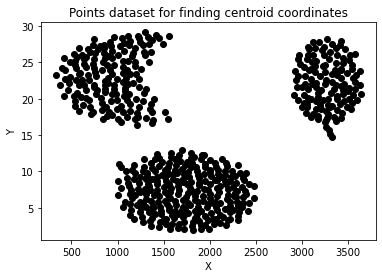

In [4]:
dataset = pd.read_table("cluster.dat", sep=" ", header=None)

normalized_dataset = StandardScaler().fit_transform(dataset)

X = dataset.iloc[:, 0:1].values
Y = dataset.iloc[:, 1:2].values

plt.scatter(X, Y, label = "Point (X;Y)", color = 'k')
plt.xlabel('X')
plt.ylabel('Y')
plt.title("Points dataset for finding centroid coordinates")
plt.show()

In [5]:
def inicializaCentroides(k, data):
    centroides = []
    for i in range(0,k):
        centroides.append(data.loc[[i]])
    return centroides

def calculaDistancia(ponto1, ponto2):
    ponto1 = ponto1.to_numpy()
    ponto2 = ponto2.to_numpy()[0]
    # distancia euclidiana
    return distance.euclidean(ponto1, ponto2)

def encontraCentroideMaisProximo(ponto, centroides, k):
    isFirst = True
    centroide = 0
    menorDistancia = -1
    for i in range(0,len(centroides)):        
        # calcula distancia pra cada centroide
        dist = calculaDistancia(ponto, centroides[i])
        if (isFirst):
            menorDistancia = dist
            isFirst = False
        elif (dist < menorDistancia):
            menorDistancia = dist
            centroide = i
    return centroide

def populaClusters(centroides, data, k):
    clusters = []
    for i in range(0,k):
        clusters.append([])
    for index, i in data.iterrows():
        
        centroide = encontraCentroideMaisProximo(i, centroides, k)
        # Passo 3: Coloca cada ponto nas classes que está mais próximo
        clusters[centroide].append(i.to_numpy())
    return clusters

def recalculaCentroides(k, centroides, clusters):
    for i in range(0,k):
        mediax=0
        mediay=0
        tam_cluster=len(clusters[i])
        for j in range(0, tam_cluster):
            mediax+=clusters[i][j][0]
            mediay+=clusters[i][j][1]
        mediax = mediax/tam_cluster
        mediay = mediay/tam_cluster
        centroides[i][0] = mediax
        centroides[i][1] = mediay
    return centroides
        
def loop_kmeans(centroides, data, k):
    clusters = populaClusters(centroides, data, k)
    centroidesAntes = copy.deepcopy(centroides)
    centroides = recalculaCentroides(k, centroides, clusters)
    return centroidesAntes, centroides, clusters
        
def convergiu(centroidesAntes, centroidesDepois, k):
    mudou = False
    for i in range(0,k):
        pontoAntes = centroidesAntes[i].to_numpy()
        pontoDepois = centroidesDepois[i].to_numpy()
        if(pontoAntes.all() == pontoDepois.all()):
            mudou = True
    return mudou
        
def kmeans(k, data, iteracoes):
    # Passo 1: Fornece valores iniciais para os centroides e agrupa
    #         o restante dos dados em um centroide
    centroides = inicializaCentroides(k, data)
    # Passo 2: Calcula distancia entre cada ponto e os centroides (passo 3 dentro de 'inicializaClusters')
    clusters = populaClusters(centroides, data, k)
    
    # Passo 4: Calcula os novos centroides para cada classe com a média
    centroidesAntes = copy.deepcopy(centroides)
    centroides = recalculaCentroides(k, centroides, clusters)
    mudou = True
    cont = 0
    # Passo 5: Repete o passo 2 em diante até convergir
    while(mudou==True and cont < iteracoes):
        centroidesAntes, centroides, clusters = loop_kmeans(centroides, data, k)
        mudou = convergiu(centroidesAntes, centroides, k)
        cont = cont + 1
    return clusters, centroides

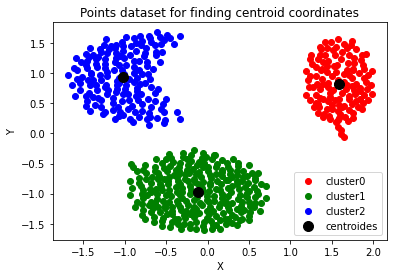

In [6]:
df = pd.DataFrame(normalized_dataset)

clusters, centroides = kmeans(3, df, 100)

# Plota clusters
cores = ['r', 'g', 'b']
for i in range(0,len(clusters)):
    arr = np.array(clusters[i])
    x, y = arr.T
    plt.scatter(x, y, c=cores[i], label='cluster'+str(i))

# Plota centroides
arr_centroides = np.array(centroides)
x, y = arr_centroides.T
plt.scatter(x, y, 100, c='black', label='centroides')
    
plt.xlabel('X')
plt.ylabel('Y')
plt.title("Points dataset for finding centroid coordinates")
plt.legend()
plt.show()

In [7]:
class CustomDBSCAN():
    def __init__(self):
        self.central = -1
        self.borda = -2

    # Encontra todos os pontos vizinhos dentro da distância epsilon
    def pontosVizinhos(self, data, pontoId, distancia):
        pontos = []
        for i in range(len(data)):
            # Distância euclidiana
            if np.linalg.norm([a_i - b_i for a_i, b_i in zip(data[i], data[pontoId])]) <= distancia:
                pontos.append(i)
        return pontos

    # Ajustar os dados no DBSCAN
    def fit(self, data, Eps, MinPt):
        # Inicializa todos os pontos como outliers
        ponto_labels = [0] * len(data)
        ponto_contador = []

        # Inicializa lista de pontos core e border
        pontos_centrais = []
        pontos_borda = []

        # Encontra os vizinhos de cada ponto
        for i in range(len(data)):
            ponto_contador.append(self.pontosVizinhos(data, i, Eps))

        # Encontra todos os pontos centrais, pontos na borda e outliers
        for i in range(len(ponto_contador)):
            if (len(ponto_contador[i]) >= MinPt):
                ponto_labels[i] = self.central
                pontos_centrais.append(i)
            else:
                pontos_borda.append(i)

        for i in pontos_borda:
            for j in ponto_contador[i]:
                if j in pontos_centrais:
                    ponto_labels[i] = self.borda
                    break

        # Associação de pontos aos clusters

        cluster = 1
        
        # Aqui, usamos uma fila para encontrar todos os pontos de vizinhança de um ponto central e encontrar os pontos indiretamente alcançáveis
        for i in range(len(ponto_labels)):
            q = queue.Queue()
            if (ponto_labels[i] == self.central):
                ponto_labels[i] = cluster
                for x in ponto_contador[i]:
                    if(ponto_labels[x] == self.central):
                        q.put(x)
                        ponto_labels[x] = cluster
                    elif(ponto_labels[x] == self.borda):
                        ponto_labels[x] = cluster
                while not q.empty():
                    vizinhos = ponto_contador[q.get()]
                    for y in vizinhos:
                        if (ponto_labels[y] == self.central):
                            ponto_labels[y] = cluster
                            q.put(y)
                        if (ponto_labels[y] == self.borda):
                            ponto_labels[y] = cluster
                cluster += 1

        return ponto_labels, cluster

    # Visualização dos clusters
    def visualize(self, data, cluster, qtdClusters):
        N = len(data)

        cores = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
                         for i in range(qtdClusters)]
        
        for i in range(qtdClusters):
            if (i == 0):
                # Plota os outliers em preto
                cor = '#000000'
            else:
                cor = cores[i % len(cores)]

            x, y = [], []
            for j in range(N):
                if cluster[j] == i:
                    x.append(data[j][0])
                    y.append(data[j][1])
            plt.scatter(x, y, c=cor, alpha=1, marker='.')
        plt.show()

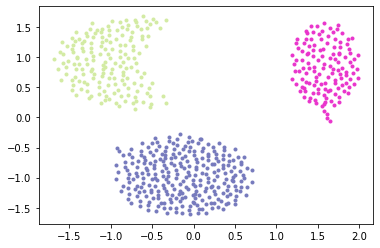

In [8]:
database = dataset.values.tolist()

custom_DBSCAN = CustomDBSCAN()
ponto_labels, clusters = custom_DBSCAN.fit(normalized_dataset, 0.25, 4)

custom_DBSCAN.visualize(normalized_dataset, ponto_labels, clusters)

In [9]:
# Lê dataset 'cluster.dat'
dataset = pd.read_table("cluster.dat", sep=" ", header=None)

X = dataset.iloc[:, 0:1].values
Y = dataset.iloc[:, 1:2].values

# split into training/test sets (90/10) -> test_size = 0.1
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=1)

df1_training = pd.DataFrame(X_train)
df2_training = pd.DataFrame(y_train)

df1_test = pd.DataFrame(X_test)
df2_test = pd.DataFrame(y_test)

df_training = pd.concat([df1_training, df2_training], axis=1)
df_test = pd.concat([df1_test, df2_test], axis=1)

df_training = df_training.to_numpy()
df_test = df_test.to_numpy()

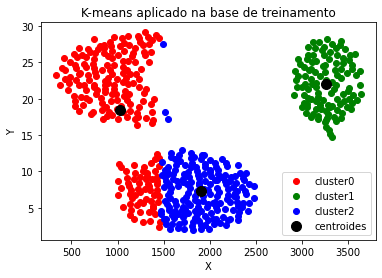

In [10]:
clusters, centroides = kmeans(3, pd.DataFrame(df_training), 100)

# Plota clusters
cores = ['r', 'g', 'b']
for i in range(0,len(clusters)):
    arr = np.array(clusters[i])
    x, y = arr.T
    plt.scatter(x, y, c=cores[i], label='cluster'+str(i))

# Plota centroides
arr_centroides = np.array(centroides)
x, y = arr_centroides.T
plt.scatter(x, y, 100, c='black', label='centroides')
    
plt.xlabel('X')
plt.ylabel('Y')
plt.title("K-means aplicado na base de treinamento")
plt.legend()
plt.show()

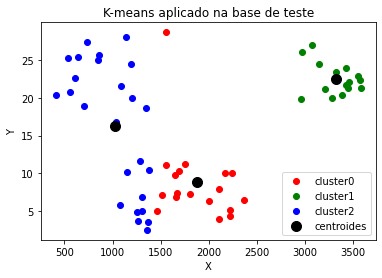

In [11]:
clusters, centroides = kmeans(3, pd.DataFrame(df_test), 100)

# Plota clusters
cores = ['r', 'g', 'b']
for i in range(0,len(clusters)):
    arr = np.array(clusters[i])
    x, y = arr.T
    plt.scatter(x, y, c=cores[i], label='cluster'+str(i))

# Plota centroides
arr_centroides = np.array(centroides)
x, y = arr_centroides.T
plt.scatter(x, y, 100, c='black', label='centroides')
    
plt.xlabel('X')
plt.ylabel('Y')
plt.title("K-means aplicado na base de teste")
plt.legend()
plt.show()

In [ ]:
url = 'https://s3-sa-east-1.amazonaws.com/ckan.saude.gov.br/Leitos/2021-04-11/esus-vepi.LeitoOcupacao.csv'
df = pd.read_csv(url, nrows=100)
df